In [377]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Define a list to store the labels
labels = []
def load_data(data_dir):
    # Define the image size for preprocessing
    img_size = (200, 200)
    genders = ['men', 'Women']
    # Define the label names and corresponding integer values
    label_names = ['0', '1', '2', '3', '4', '5']
    label_dict = {label_names[i]: i for i in range(len(label_names))}

    # Initialize empty lists for the images and labels
    images = []

    # Loop over the gender folders
    for gender in genders:
        gender_dir = os.path.join(data_dir, gender)
        # Loop over the label names
        for label_name in label_names:
            # Get the path to the label folder
            label_dir = os.path.join(gender_dir, label_name)
            # Loop over the images in the label folder
            for file_name in os.listdir(label_dir):
                # Get the path to the image file
                file_path = os.path.join(label_dir, file_name)
                # Load the image file and preprocess it
                img = cv2.imread(file_path)
                if img is None:
                    continue
        
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                # Append the preprocessed image and corresponding label to the lists
                images.append(img_normalized)
                labels.append(label_dict[label_name])

    # Convert the image and label lists to numpy arrays
    X_train = np.array(images)
    y_train = np.array(labels)
    
    return X_train, y_train

In [378]:
# Load the data
X_train, y_train = load_data('Dataset_0-5/')
print(len(y_train))

1821


In [379]:
# Define a function to remove shadows from an image
def remove_shadows(image):
    # convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # split the LAB channels
    l, a, b = cv2.split(lab)
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))
    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result

In [380]:
# Define a function to preprocess images using thresholding
def preprocess_images_thresh(images):
    X_processed = []
    light_skin = np.array([8, 50, 50],np.uint8)
    dark_skin = np.array([50, 255, 255],np.uint8)  
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        blur_img = cv2.GaussianBlur(img,(5,5),0)
        denoised_img = cv2.fastNlMeansDenoisingColored(blur_img,None,3,3,7,21)
        # Convert the denoised image to HSV color space
        hsv_img = cv2.cvtColor(denoised_img,cv2.COLOR_BGR2HSV)
        # Threshold the image based on skin color
        frame_threshed = cv2.inRange(hsv_img, light_skin, dark_skin)
        # Append the thresholded image to the processed images list
        X_processed.append(frame_threshed)
    # Convert the processed images list to a numpy array
    X_processed = np.array(X_processed)
    return X_processed


In [381]:
def preprocess_images_blurred(images):
    X_processed = [] 
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred_input = cv2.medianBlur(gray,5)
        X_processed.append(blurred_input)
    
    X_processed = np.array(X_processed)
    return X_processed


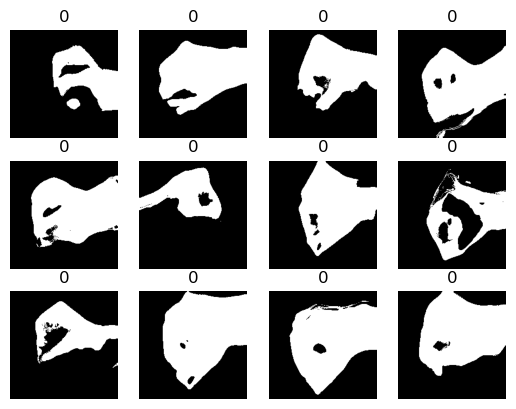

In [382]:
# Preprocess the training images using thresholding
X_train_processed = preprocess_images_thresh(X_train)
# Visualize the processed images
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i], cmap='gray')
    plt.title(y_train[i+33])
    plt.axis('off')


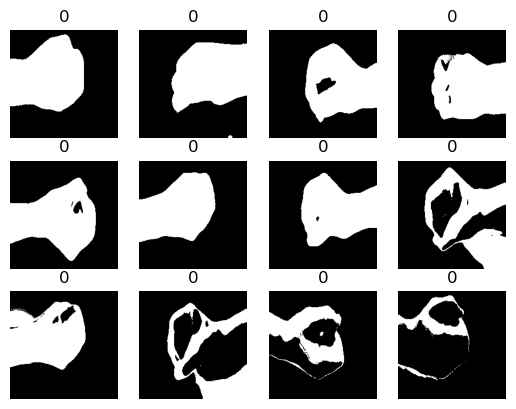

In [383]:
# Visualize more processed images
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i+33], cmap='gray')
    plt.title(y_train[i+40])
    plt.axis('off')

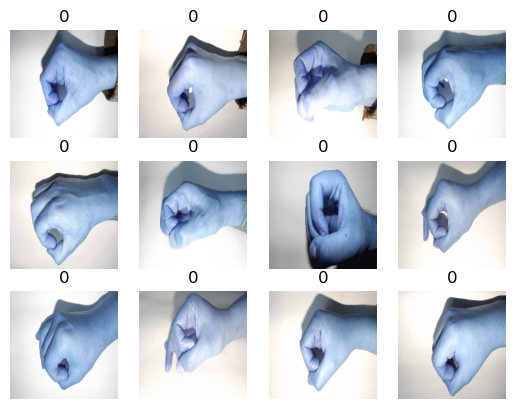

In [384]:
# Visualize original unprocessed images
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train[i+6], cmap='gray')
    plt.title(y_train[i+6])
    plt.axis('off')

In [480]:
from skimage.feature import hog
from skimage import exposure

# Define a function to extract Hu Moments as a feature from grayscale images
def extract_hu_moments(grayscale_img):
    moments = cv2.moments(grayscale_img)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log-scale the Hu moments to make them more invariant to changes in scale
    log_hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    # Return only the first two Hu moments
    return log_hu_moments[:2].flatten()

# Preprocess the images to extract features using HOG
X_hog = []
for i in range(len(X_train)):
    img = X_train[i]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_input = cv2.medianBlur(gray,5)
    X_hog.append(blurred_input)

X_hog = np.array(X_hog)
    
# Placeholder feature descriptors to store the features
feature_descriptor = []
hog_imgs = []

# Extract HOG features from the preprocessed images
for i in range(0,len(X_hog)):
    feature_descriptor_i = hog(X_hog[i], orientations=9, pixels_per_cell=(10, 10),
                	cells_per_block=(2, 2), visualize=False)
    feature_descriptor.append(feature_descriptor_i)

In [485]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Split the data into training and testing sets
x_fit, x_test, y_fit, y_test = train_test_split(feature_descriptor, y_train, test_size=0.25)

# Initialize an SVM classifier with specified hyperparameters
clf = SVC(kernel='rbf',C=100,gamma=0.001)

# Fit the training data to the classifier
clf = clf.fit(x_fit,y_fit)

# Predict the labels for the test data
pred_y = clf.predict(x_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test,pred_y)

# Print the accuracy
print('Accuracy: {} % '. format(accuracy * 100))


Accuracy: 68.42105263157895 % 


In [ ]:
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf'] }

#Create the GridSearchCV object
grid_clf = GridSearchCV(SVC(class_weight='balanced'), params_grid,verbose=3,refit=True)

#Fit the data with the best possible parameters
grid_clf = grid_clf.fit(x_fit, y_fit)

#Print the best estimator with it's parameters
print(grid_clf.best_estimator_)